In [14]:
import pandas as pd
import numpy as np

DATA_PATH = "/content/data.csv"

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", None)

df = pd.read_csv(DATA_PATH)
N, M = df.shape

cutoff = max(10, int(0.01 * N))
ordinal_hints = {"rank","rating","level","grade","order","stage","tier","score"}

def classify_var(col: pd.Series) -> str:
    if pd.api.types.is_numeric_dtype(col):
        return "categorical (numeric-codes likely)" if col.nunique(dropna=True) <= cutoff else "continuous"
    if pd.api.types.is_datetime64_any_dtype(col):
        return "datetime/continuous"
    return "categorical"

def scale_label(var_type: str, name: str) -> str:
    if var_type.startswith("continuous"):
        return "numeric (interval/ratio)"
    if "datetime" in var_type:
        return "datetime"
    n = (name or "").lower()
    return "ordinal" if any(k in n for k in ordinal_hints) else "nominal"

rows = []
for c in df.columns:
    col = df[c]
    var_type = classify_var(col)
    scale = scale_label(var_type, c)
    n_unique = int(col.nunique(dropna=True))
    n_missing = int(col.isna().sum())
    miss_pct = 100.0 * n_missing / len(col)

    note = ""
    if var_type.startswith("continuous") or "datetime" in var_type:
        vals = pd.to_numeric(col, errors="coerce")
        mu = float(np.nanmean(vals))
        sd = float(np.nanstd(vals, ddof=1)) if vals.notna().sum() > 1 else np.nan
        note = f"μ≈{mu:.3g}, σ≈{sd:.3g}"
    else:
        vc = col.value_counts(dropna=True).head(3)
        if len(vc) > 0:
            tops = "; ".join([f"{str(k)}({int(v)})" for k, v in vc.items()])
            note = f"top: {tops}"

    rows.append({
        "name": c,
        "dtype": str(col.dtype),
        "var_type": var_type,
        "scale": scale,
        "n_unique": n_unique,
        "missing_%": round(miss_pct, 3),
        "notes": note
    })

summary_df = pd.DataFrame(rows)

is_cont = summary_df["var_type"].apply(lambda v: v.startswith("continuous") or "datetime" in v)
continuous_count = int(is_cont.sum())
categorical_count = int((~is_cont).sum())

print("How many observations?\n")
print(f"Rows: {N:,}")
print(f"Columns: {M:,}\n")

print("Columns, scales, and distributions\n")
print(f"Heuristic typing: {continuous_count} continuous, {categorical_count} categorical (including string/ID-like or low-cardinality numeric).")
print("Per-column summary (dtype, variable type, scale, cardinality, missing%, plus brief notes):\n")

cols_order = ["name","dtype","var_type","scale","n_unique","missing_%","notes"]
display(summary_df[cols_order])

# Save for download
summary_csv = "/content/column_summary.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\nSaved per-column table to: {summary_csv}")

missing_total = int(df.isna().sum().sum())
rows_with_any_missing = int(df.isna().any(axis=1).sum())
duplicate_rows = int(df.duplicated().sum())

print("\nMissing and duplicate values\n")
print(f"Missing cells: {missing_total} (rows with any missing: {rows_with_any_missing})")
print(f"Duplicate rows: {duplicate_rows}")

label_map = {
    1: "Ramnit",
    2: "Lollipop",
    3: "Kelihos_ver3",
    4: "Vundo",
    5: "Simda",
    6: "Tracur",
    7: "Kelihos_ver1",
    8: "Obfuscator.ACY",
    9: "Gatak",
}

if "Class" in df.columns:
    vc = df["Class"].value_counts(dropna=False).sort_index()
    dist_rows = []
    for k in range(1, 10):
        cnt = int(vc.get(k, 0))
        pct = 100.0 * cnt / N
        dist_rows.append({"Label": k, "Family": label_map[k], "Count": f"{cnt:,}", "Percent": f"{pct:.2f}%"})
    class_dist_df = pd.DataFrame(dist_rows, columns=["Label","Family","Count","Percent"])

    print("\nTarget column and labels\n")
    print("Target candidate: Class (multi-class).")
    print("Label → family mapping")
    for k in range(1,10):
        print(f"{k}: {label_map[k]}")
    print("\nClass distribution\n")
    display(class_dist_df)

    class_csv = "/content/class_distribution.csv"
    class_dist_df.to_csv(class_csv, index=False)
    print(f"Saved class distribution to: {class_csv}")
else:
    print("\nNo 'Class' column found.")


How many observations?

Rows: 10,868
Columns: 69

Columns, scales, and distributions

Heuristic typing: 55 continuous, 14 categorical (including string/ID-like or low-cardinality numeric).
Per-column summary (dtype, variable type, scale, cardinality, missing%, plus brief notes):



,name,dtype,var_type,scale,n_unique,missing_%,notes
0,asm_commands_add,int64,continuous,numeric (interval/ratio),2122,0.0,"μ≈724, σ≈1.57e+03"
1,asm_commands_call,float64,continuous,numeric (interval/ratio),1993,0.0,"μ≈959, σ≈2.89e+03"
2,asm_commands_cdq,float64,continuous,numeric (interval/ratio),191,0.0,"μ≈10.8, σ≈39.1"
3,asm_commands_cld,float64,continuous,numeric (interval/ratio),210,0.0,"μ≈200, σ≈1.57e+03"
4,asm_commands_cli,float64,continuous,numeric (interval/ratio),200,0.0,"μ≈16.8, σ≈184"
5,asm_commands_cmc,float64,categorical (numeric-codes likely),nominal,54,0.0,top: 0.0(9403); 1.0(502); 2.0(245)
6,asm_commands_cmp,float64,continuous,numeric (interval/ratio),1563,0.0,"μ≈480, σ≈1.38e+03"
7,asm_commands_cwd,float64,categorical (numeric-codes likely),nominal,46,0.0,top: 0.0(8761); 1.0(609); 2.0(355)
8,asm_commands_daa,float64,continuous,numeric (interval/ratio),1007,0.0,"μ≈221, σ≈498"
9,asm_commands_dd,int64,continuous,numeric (interval/ratio),6180,0.0,"μ≈1.7e+04, σ≈3.29e+04"



Saved per-column table to: /content/column_summary.csv

Missing and duplicate values

Missing cells: 0 (rows with any missing: 0)
Duplicate rows: 80

Target column and labels

Target candidate: Class (multi-class).
Label → family mapping
1: Ramnit
2: Lollipop
3: Kelihos_ver3
4: Vundo
5: Simda
6: Tracur
7: Kelihos_ver1
8: Obfuscator.ACY
9: Gatak

Class distribution



,Label,Family,Count,Percent
0,1,Ramnit,"1,541",14.18%
1,2,Lollipop,"2,478",22.80%
2,3,Kelihos_ver3,"2,942",27.07%
3,4,Vundo,475,4.37%
4,5,Simda,42,0.39%
5,6,Tracur,751,6.91%
6,7,Kelihos_ver1,398,3.66%
7,8,Obfuscator.ACY,"1,228",11.30%
8,9,Gatak,"1,013",9.32%


Saved class distribution to: /content/class_distribution.csv


Loaded: /content/data.csv  shape=(10868, 69)


/tmp/ipython-input-419266236.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, rotation=30, ha="right")


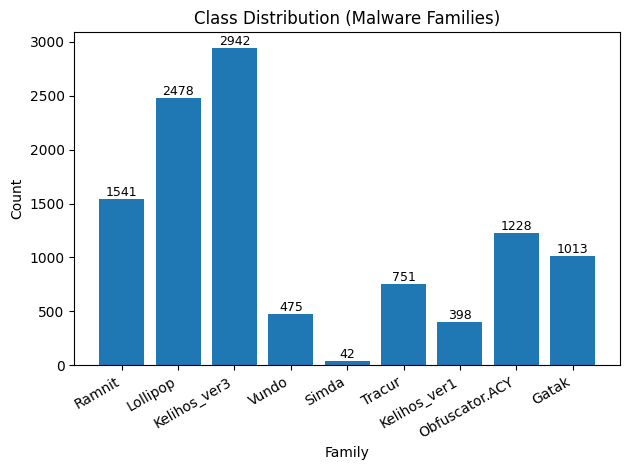

Saved: /content/plots/class_distribution_bar.png
Explanation: Each bar shows how many samples per malware family. Big differences indicate class imbalance (rare vs common families).


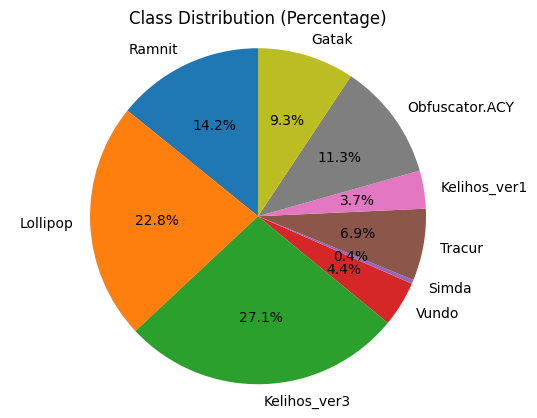

Saved: /content/plots/class_distribution_pie.png
Explanation: The pie shows the share of the dataset each family occupies. Good for eyeballing imbalance by proportion.



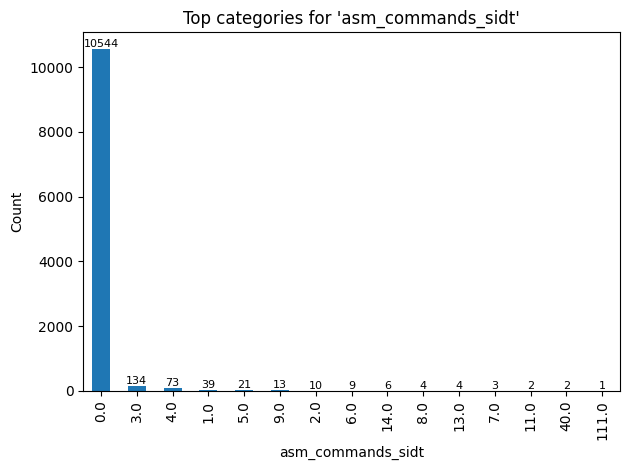

Saved: /content/plots/bar_asm_commands_sidt.png
Explanation: Bar chart shows the most frequent values for 'asm_commands_sidt'. Useful for spotting dominant categories or potential encoding issues.



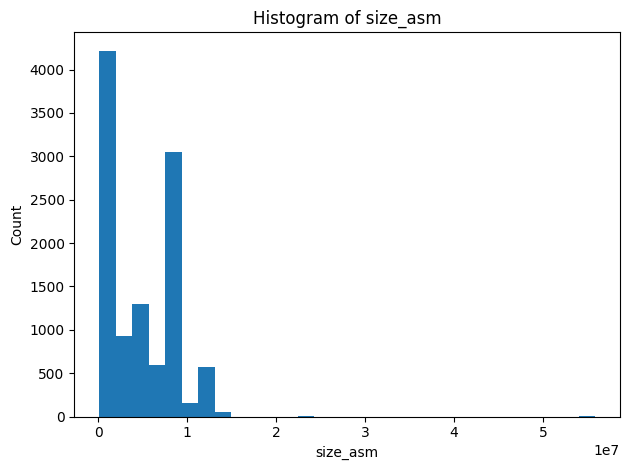

Saved: /content/plots/hist_size_asm.png
Explanation: Histogram shows the value distribution for 'size_asm'. You can spot skewness, multi-modality, and outliers.



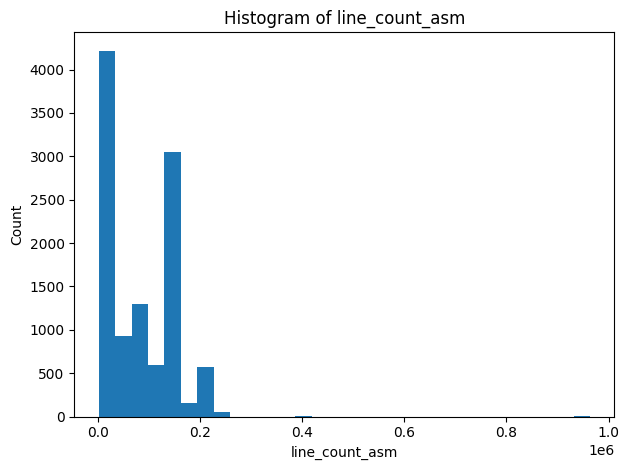

Saved: /content/plots/hist_line_count_asm.png
Explanation: Histogram shows the value distribution for 'line_count_asm'. You can spot skewness, multi-modality, and outliers.



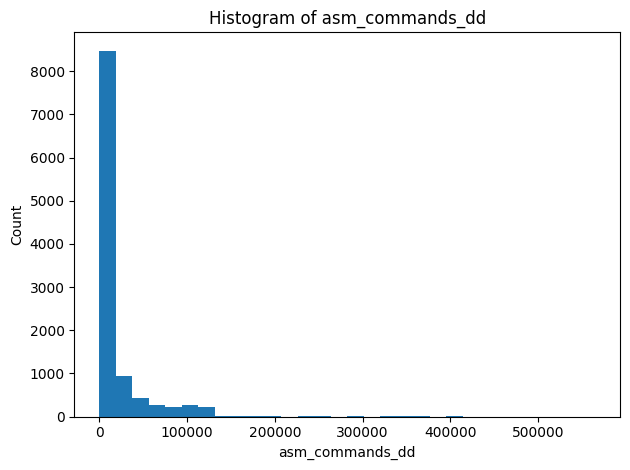

Saved: /content/plots/hist_asm_commands_dd.png
Explanation: Histogram shows the value distribution for 'asm_commands_dd'. You can spot skewness, multi-modality, and outliers.



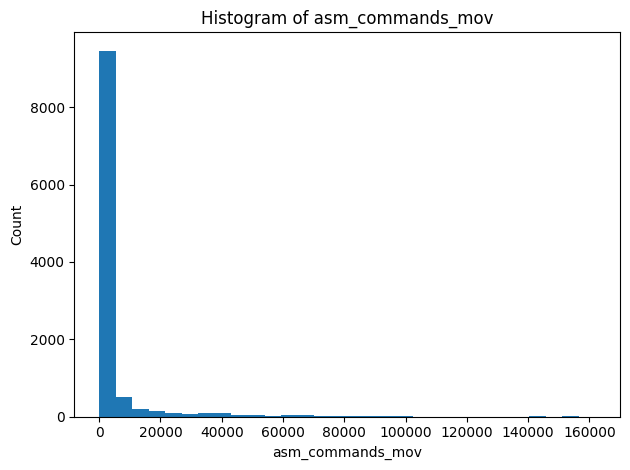

Saved: /content/plots/hist_asm_commands_mov.png
Explanation: Histogram shows the value distribution for 'asm_commands_mov'. You can spot skewness, multi-modality, and outliers.



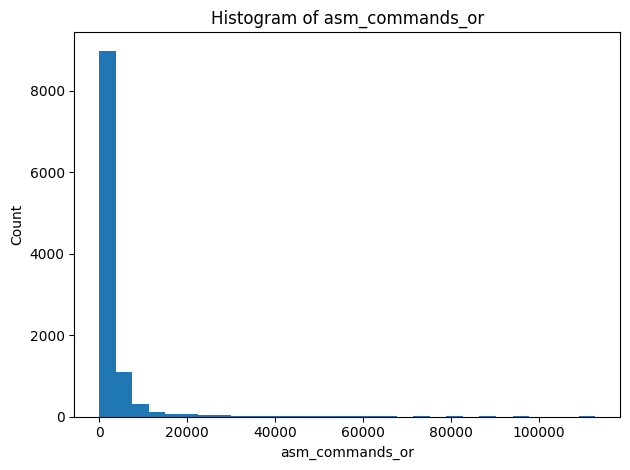

Saved: /content/plots/hist_asm_commands_or.png
Explanation: Histogram shows the value distribution for 'asm_commands_or'. You can spot skewness, multi-modality, and outliers.



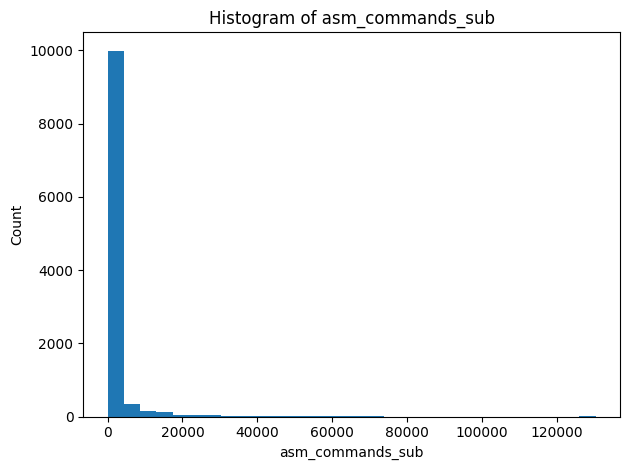

Saved: /content/plots/hist_asm_commands_sub.png
Explanation: Histogram shows the value distribution for 'asm_commands_sub'. You can spot skewness, multi-modality, and outliers.



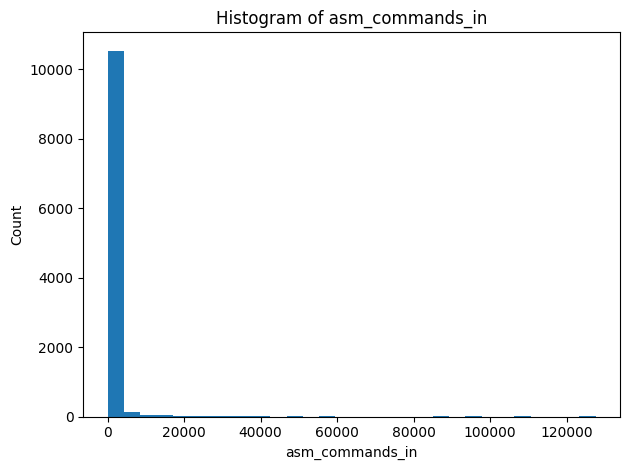

Saved: /content/plots/hist_asm_commands_in.png
Explanation: Histogram shows the value distribution for 'asm_commands_in'. You can spot skewness, multi-modality, and outliers.



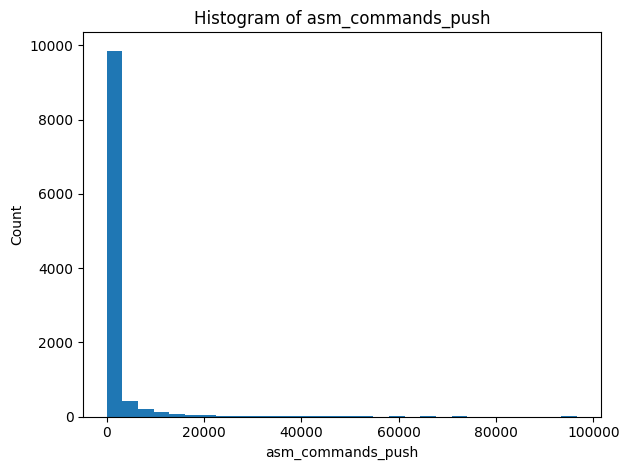

Saved: /content/plots/hist_asm_commands_push.png
Explanation: Histogram shows the value distribution for 'asm_commands_push'. You can spot skewness, multi-modality, and outliers.



/tmp/ipython-input-419266236.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(len(classes), 3))


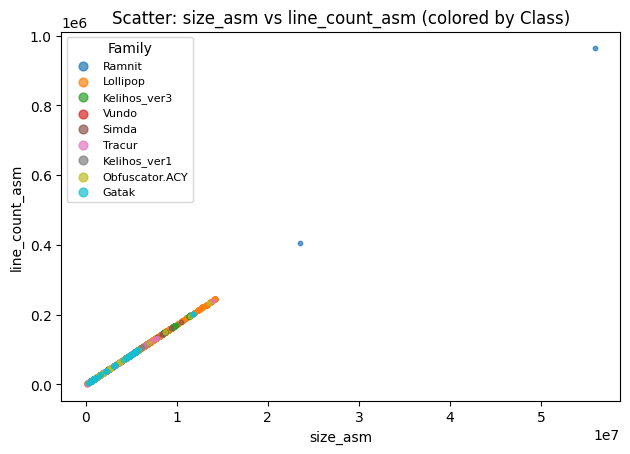

Saved: /content/plots/scatter_size_asm_vs_line_count_asm.png
Explanation: Scatter plot shows the relationship between two features. Clusters or separable regions by color (family) suggest features that help classification.

Building scatter matrix for: ['size_asm', 'line_count_asm', 'asm_commands_dd', 'asm_commands_mov']


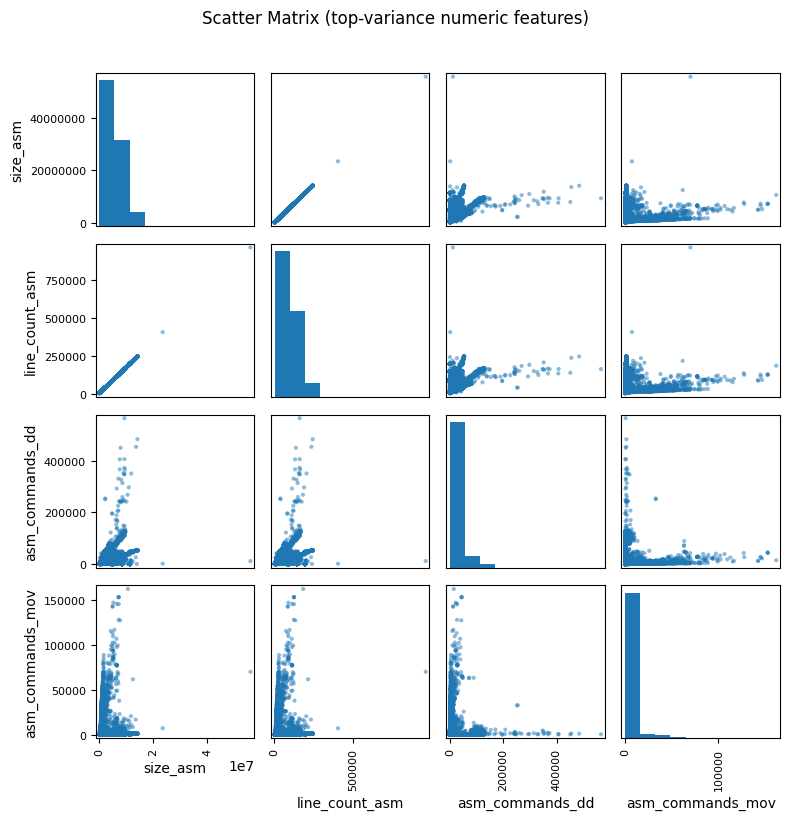

Saved: /content/plots/scatter_matrix.png
Explanation: Scatter-matrix shows pairwise relationships among selected features. Look for linear/nonlinear trends and unusually wide or tight spreads.

Done. All figures saved under /content/plots


In [13]:

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

path_candidates = [
    "/content/data.csv",
    "/content/data/data.csv",
    "data/data.csv"
]
data_path = next((p for p in path_candidates if os.path.exists(p)), None)
if data_path is None:
    raise FileNotFoundError("Could not find data.csv. Upload it to /content or set the correct path.")

df = pd.read_csv(data_path)
print(f"Loaded: {data_path}  shape={df.shape}")

label_map = {
    1: "Ramnit",
    2: "Lollipop",
    3: "Kelihos_ver3",
    4: "Vundo",
    5: "Simda",
    6: "Tracur",
    7: "Kelihos_ver1",
    8: "Obfuscator.ACY",
    9: "Gatak",
}

os.makedirs("/content/plots", exist_ok=True)


if "Class" in df.columns:
    class_counts = df["Class"].value_counts().sort_index()
    class_labels = [label_map.get(int(c), str(c)) for c in class_counts.index]

    fig, ax = plt.subplots()
    ax.bar(class_labels, class_counts.values)
    ax.set_title("Class Distribution (Malware Families)")
    ax.set_xlabel("Family")
    ax.set_ylabel("Count")
    ax.set_xticklabels(class_labels, rotation=30, ha="right")
    for i, v in enumerate(class_counts.values):
        ax.text(i, v, str(v), ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    out = "/content/plots/class_distribution_bar.png"
    fig.savefig(out, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}\nExplanation: Each bar shows how many samples per malware family. "
          "Big differences indicate class imbalance (rare vs common families).")

    fig, ax = plt.subplots()
    ax.pie(class_counts.values, labels=class_labels, autopct="%1.1f%%", startangle=90)
    ax.set_title("Class Distribution (Percentage)")
    ax.axis("equal")
    out = "/content/plots/class_distribution_pie.png"
    fig.savefig(out, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}\nExplanation: The pie shows the share of the dataset each family occupies. "
          "Good for eyeballing imbalance by proportion.\n")
else:
    print("No 'Class' column found — skipping class distribution plots.")

cat_candidates = []
for c in df.columns:
    nun = df[c].nunique(dropna=True)
    if df[c].dtype == "object" or nun <= 20:
        if c != "Class":
            cat_candidates.append(c)

cat_to_plot = cat_candidates[:3]
for c in cat_to_plot:
    vc = df[c].value_counts(dropna=False).head(15)
    fig, ax = plt.subplots()
    vc.plot(kind="bar", ax=ax)
    ax.set_title(f"Top categories for '{c}'")
    ax.set_xlabel(c)
    ax.set_ylabel("Count")
    for i, v in enumerate(vc.values):
        ax.text(i, v, str(v), ha="center", va="bottom", fontsize=8, rotation=0)
    fig.tight_layout()
    out = f"/content/plots/bar_{c}.png"
    fig.savefig(out, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}\nExplanation: Bar chart shows the most frequent values for '{c}'. "
          "Useful for spotting dominant categories or potential encoding issues.\n")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

num_cols_sorted = sorted(num_cols, key=lambda col: df[col].var(skipna=True), reverse=True)
hist_cols = num_cols_sorted[:8]

for col in hist_cols:
    vals = pd.to_numeric(df[col], errors="coerce").dropna()
    fig, ax = plt.subplots()
    ax.hist(vals, bins=30)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    fig.tight_layout()
    out = f"/content/plots/hist_{col}.png"
    fig.savefig(out, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}\nExplanation: Histogram shows the value distribution for '{col}'. "
          "You can spot skewness, multi-modality, and outliers.\n")

if len(num_cols) >= 2:
    xcol, ycol = num_cols_sorted[0], num_cols_sorted[1]
    fig, ax = plt.subplots()
    if "Class" in df.columns:
        classes = sorted(df["Class"].dropna().unique())
        cmap = plt.cm.get_cmap("tab10", max(len(classes), 3))
        for i, cls in enumerate(classes):
            mask = df["Class"] == cls
            ax.scatter(df.loc[mask, xcol], df.loc[mask, ycol], s=10, label=label_map.get(int(cls), str(cls)), alpha=0.7, c=[cmap(i)])
        ax.legend(title="Family", markerscale=2, fontsize=8)
        title_suffix = " (colored by Class)"
    else:
        ax.scatter(df[xcol], df[ycol], s=10, alpha=0.7)
        title_suffix = ""

    ax.set_title(f"Scatter: {xcol} vs {ycol}{title_suffix}")
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    fig.tight_layout()
    out = f"/content/plots/scatter_{xcol}_vs_{ycol}.png"
    fig.savefig(out, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}\nExplanation: Scatter plot shows the relationship between two features. "
          "Clusters or separable regions by color (family) suggest features that help classification.\n")
if len(num_cols_sorted) >= 4:
    sm_cols = num_cols_sorted[:4]
    print(f"Building scatter matrix for: {sm_cols}")
    sm_df = df[sm_cols].copy()
    axs = scatter_matrix(sm_df, diagonal="hist", figsize=(8, 8))
    plt.suptitle("Scatter Matrix (top-variance numeric features)", y=1.02)
    plt.tight_layout()
    out = "/content/plots/scatter_matrix.png"
    plt.savefig(out, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}\nExplanation: Scatter-matrix shows pairwise relationships among selected features. "
          "Look for linear/nonlinear trends and unusually wide or tight spreads.\n")

print("Done. All figures saved under /content/plots")


Loading: /content/data.csv


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline macro-F1: 0.845

Top-5 columns (by macro-F1 drop when permuted):
           column  importance_drop_macroF1
   line_count_asm                 0.099816
         size_asm                 0.090650
  asm_commands_dd                 0.073983
 asm_commands_jmp                 0.070917
asm_commands_push                 0.060438


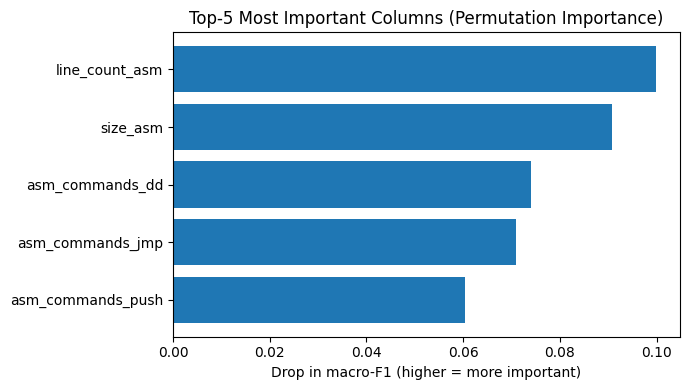

Saved plot to: /content/plots_all/top5_feature_importance_permutation.png

Explanation:
- Permutation importance = macro-F1 decrease when a column's values are randomly shuffled.
- Larger drop means the model relied more on that column for predictions.
- This is model-agnostic and computed per ORIGINAL column (not one-hot components).


In [12]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

CANDIDATES = ["/content/data.csv", "/content/data/data.csv", "data/data.csv"]
data_path = next((p for p in CANDIDATES if os.path.exists(p)), None)
if data_path is None:
    raise FileNotFoundError("Upload data.csv to /content or set the correct path in CANDIDATES.")
print("Loading:", data_path)

df = pd.read_csv(data_path)
assert "Class" in df.columns, "Expected a 'Class' target column."
y = df["Class"]
X = df.drop(columns=["Class"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)
pipe = make_pipeline(pre, LogisticRegression(max_iter=2000, multi_class="multinomial"))

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_tr, y_tr)

y_hat = pipe.predict(X_te)
baseline = f1_score(y_te, y_hat, average="macro")
print("Baseline macro-F1:", round(baseline, 4))

def perm_importance_by_column(pipe, X_te: pd.DataFrame, y_te, n_repeats=5, seed=123):
    rng = np.random.RandomState(seed)
    base_pred = pipe.predict(X_te)
    base = f1_score(y_te, base_pred, average="macro")

    drops = {}
    for col in X_te.columns:
        scores = []
        vals = X_te[col].to_numpy(copy=True)
        for r in range(n_repeats):
            shuffled = vals.copy()
            rng.shuffle(shuffled)
            Xp = X_te.copy()
            Xp[col] = shuffled
            pred = pipe.predict(Xp)
            score = f1_score(y_te, pred, average="macro")
            scores.append(base - score)
        drops[col] = float(np.mean(scores))
    return drops

drops = perm_importance_by_column(pipe, X_te, y_te, n_repeats=5, seed=123)

imp_df = pd.DataFrame(
    sorted(drops.items(), key=lambda kv: kv[1], reverse=True),
    columns=["column", "importance_drop_macroF1"]
)
top5 = imp_df.head(5)
print("\nTop-5 columns (by macro-F1 drop when permuted):")
print(top5.to_string(index=False))

os.makedirs("/content/plots_all", exist_ok=True)
fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(top5["column"][::-1], top5["importance_drop_macroF1"][::-1])
ax.set_xlabel("Drop in macro-F1 (higher = more important)")
ax.set_title("Top-5 Most Important Columns (Permutation Importance)")
fig.tight_layout()
out = "/content/plots_all/top5_feature_importance_permutation.png"
fig.savefig(out, dpi=140, bbox_inches="tight")
plt.show()
print("Saved plot to:", out)

print(
    "\nExplanation:\n"
    "- Permutation importance = macro-F1 decrease when a column's values are randomly shuffled.\n"
    "- Larger drop means the model relied more on that column for predictions.\n"
    "- This is model-agnostic and computed per ORIGINAL column (not one-hot components)."
)


Variance for each numeric column (ascending):
asm_commands_sidt     2.102955e+00
Class                 7.207190e+00
asm_commands_fistp    1.953249e+01
asm_commands_jno      4.787834e+01
asm_commands_fdivr    6.089122e+01
                          ...     
asm_commands_or       5.883105e+07
asm_commands_mov      1.349746e+08
asm_commands_dd       1.083496e+09
line_count_asm        4.157071e+09
size_asm              1.398438e+13
Length: 69, dtype: float64
